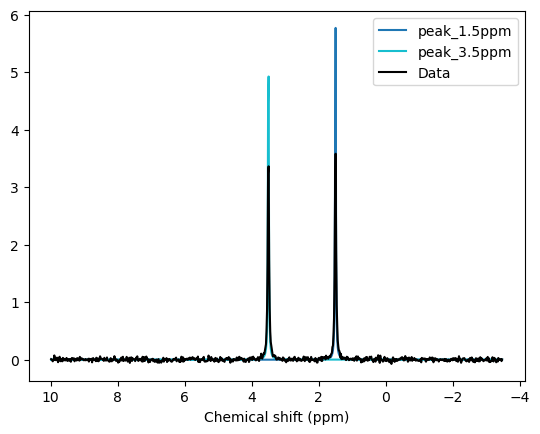

In [154]:
from scipy.linalg import circulant
import numpy as np
import matplotlib.pyplot as plt

from fsl_mrs.utils.misc import FIDToSpec
from fsl_mrs.utils.synthetic.synthetic import syntheticFID
from fsl_mrs.core import MRS, basis
from fsl_mrs.utils.preproc import apodize

npoints = 1024
noise_sd = 0.001
bandwidth = 2000

def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    complex_noise_sd = np.sqrt(noise_sd + noise_sd)
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = FIDToSpec(window ** 2) * complex_noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))

chemical_shifts = np.asarray([1.5, 3.5]) - 4.65
basis_fid_array = []
for shift in chemical_shifts:
    FID, header = syntheticFID(
        noisecovariance=[[0]],
        chemicalshift=[shift,],
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[3,]
    )
    basis_fid_array.append(FID[0])
    header['fwhm'] = 1.0


spec_basis = basis.Basis(
    np.stack(basis_fid_array),
    [f'peak_{x+4.65}ppm' for x in chemical_shifts],
    [header, ] * len(chemical_shifts))


FIDs, header = syntheticFID(
    noisecovariance=[[noise_sd]],
    chemicalshift=chemical_shifts,
    points=npoints,
    bandwidth=bandwidth,
    linewidth=[5, 5]
)

FID = apodize(
    FIDs[0],
    1 / bandwidth,
    1)


example_mrs = MRS(FID=FID, header=header, basis=spec_basis)

_ = example_mrs.plot_basis(add_spec=True, ppmlim=(-10,10))

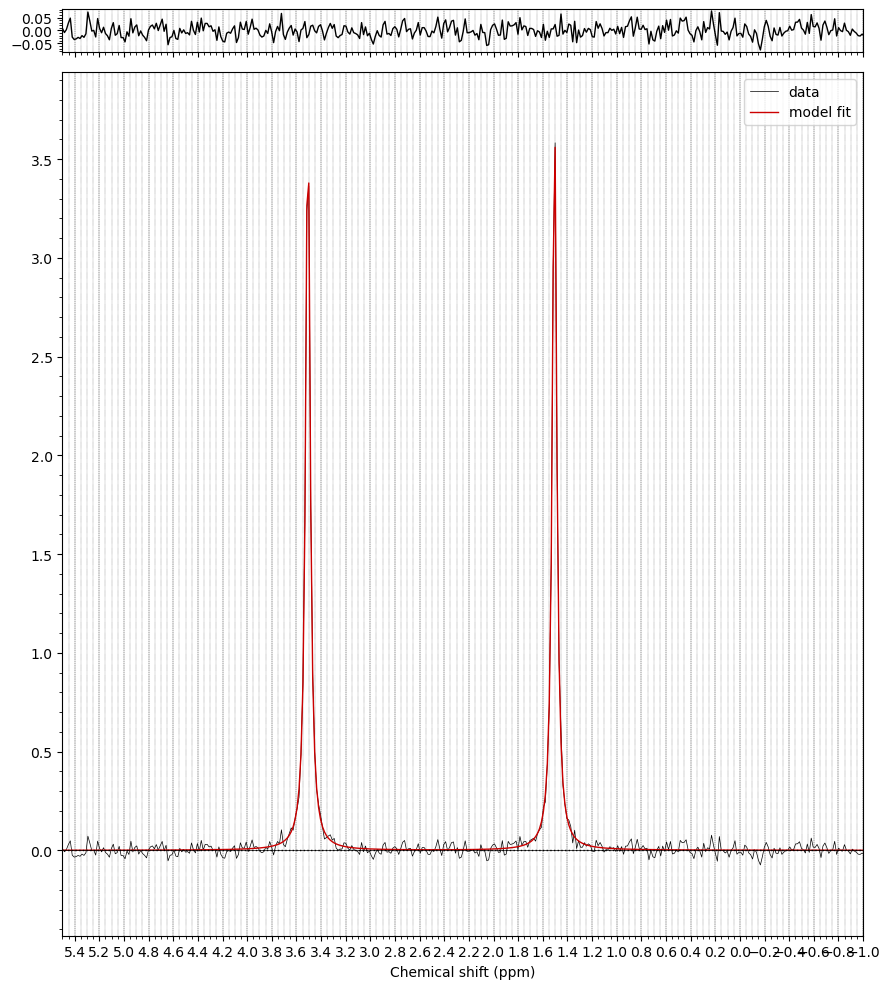

In [158]:
example_res = example_mrs.fit(baseline='off', ppmlim=(-1, 5.5))
_ = example_res.plot(example_mrs)

In [175]:

def mc_fitting_func(noise_sd, apod_hz=0):
    FIDs, header = syntheticFID(
        noisecovariance=[[noise_sd]],
        chemicalshift=chemical_shifts,
        points=npoints,
        bandwidth=bandwidth,
        linewidth=[5, 5]
    )

    if apod_hz > 0:
        FID = apodize(
            FIDs[0],
            1 / bandwidth,
            apod_hz)
    else:
        FID = FIDs[0]
    mrs = MRS(FID=FID, header=header, basis=spec_basis)
    res = mrs.fit(baseline='off', ppmlim=(-1, 5.5))
    return res.fitResults.iloc[0], res.cov

accumulated_param, accumulated_cov = [], []
n_mc_reps = 1000
for rep in range(n_mc_reps):
    param, cov = mc_fitting_func(0.001, apod_hz=10)
    accumulated_param.append(param)
    accumulated_cov.append(cov)
import pandas as pd
mc_results = pd.DataFrame(accumulated_param).reset_index(drop=True)


In [180]:
mc_results.mean()

peak_1.5ppm    1.007317e+00
peak_3.5ppm    1.007400e+00
gamma_0        1.619964e+01
sigma_0        6.739475e-01
eps_0         -2.408054e-03
Phi0           9.291277e-05
Phi1           4.949021e-07
B_real_0       0.000000e+00
B_imag_0       0.000000e+00
dtype: float64

In [176]:
mean_cov = np.stack(accumulated_cov).mean(axis=0)
np.diag(mean_cov)

array([4.902e-06, 4.912e-06, 1.153e-02, 2.123e+04, 3.299e-03, 8.173e-06,
       7.858e-11, 2.699e-07, 2.405e-07])

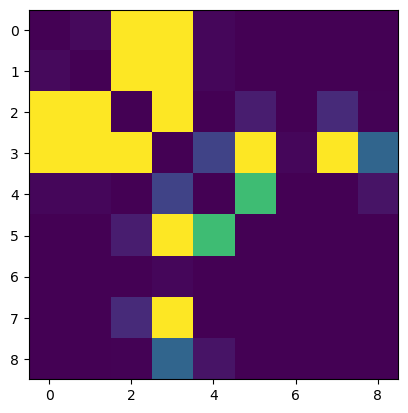

In [177]:
import matplotlib.pyplot as plt
no_diag_cov = mean_cov - np.diag(np.diag(mean_cov))
plt.imshow(np.abs(no_diag_cov), vmin=0, vmax=1E-4)

In [178]:
mc_results.var()

peak_1.5ppm    3.651365e-05
peak_3.5ppm    3.287667e-05
gamma_0        4.677119e-02
sigma_0        6.251137e-01
eps_0          1.539671e-02
Phi0           5.285561e-05
Phi1           5.080528e-10
B_real_0       0.000000e+00
B_imag_0       0.000000e+00
dtype: float64